## SetUp

In [24]:
# Librerías para manejo de datos
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Librerías para preprocesamiento y modelado
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

# Librerías para métricas y evaluación
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve

# Librerías para visualización
import matplotlib.pyplot as plt

# Librerías para redes neuronales y optimización
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
# Librerías para ajuste de hiperparámetros
from keras_tuner.tuners import RandomSearch
import keras_tuner as kt

# Librerías estadísticas
from scipy.stats import pointbiserialr

colors = ['darkblue', 'orange', 'green', 'red', 'purple']

In [19]:
pip install shap

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
#importacion df_final
df=pd.read_csv('../data/processed/v3_final_merge.csv')

## Data processing and exploration

In [3]:
df

,edad,sexo,nivel_educativo,fumador,actividad_fisica,vive,diabetes,hipertension,obesidad,cancer,...,region_Sur,tipo_empleo_Desempleado,tipo_empleo_Privado,tipo_empleo_Público,tipo_empleo_Temporal,continente_America,continente_Antarctica,continente_Asia,continente_Europe,continente_Oceania
0,69,0,1,1,0,1,1,1,1,0,...,0,0,0,1,0,0,0,1,0,0
1,32,1,2,0,1,0,0,0,0,0,...,1,0,0,0,1,1,0,0,0,0
2,89,1,0,1,0,1,0,0,0,0,...,0,1,0,0,0,1,0,0,0,0
3,78,1,1,1,0,0,1,0,1,1,...,0,0,0,0,1,0,0,1,0,0
4,38,0,3,1,1,1,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,21,1,2,0,2,1,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
49996,35,0,3,0,1,1,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
49997,46,1,1,0,1,1,0,0,0,0,...,0,1,0,0,0,0,0,0,1,0
49998,56,1,3,1,1,1,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0


In [3]:
df.shape

(50000, 48)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 48 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   edad                     50000 non-null  int64  
 1   sexo                     50000 non-null  int64  
 2   nivel_educativo          50000 non-null  int64  
 3   fumador                  50000 non-null  int64  
 4   actividad_fisica         50000 non-null  int64  
 5   vive                     50000 non-null  int64  
 6   diabetes                 50000 non-null  int64  
 7   hipertension             50000 non-null  int64  
 8   obesidad                 50000 non-null  int64  
 9   cancer                   50000 non-null  int64  
 10  enfermedad_cardiaca      50000 non-null  int64  
 11  epoc                     50000 non-null  int64  
 12  glucosa                  50000 non-null  float64
 13  colesterol               50000 non-null  float64
 14  trigliceridos         

## Correlation

A continuación, vamos a estudiar la **correlación** de las variables con la clase objetivo que queremos predecir, es decir, si el paciente **vive o no**. Este análisis nos permitirá identificar qué variables tienen una relación más fuerte con la variable objetivo, lo que puede ser útil para seleccionar las características más relevantes para nuestra red neuronal.

In [4]:
X = df.drop(columns=['vive'])
y = df['vive']

# Calcular correlaciones
correlaciones = {}

for col in X.columns:
    if pd.api.types.is_numeric_dtype(df[col]):
        try:
            corr, _ = pointbiserialr(df[col], y)
            correlaciones[col] = corr
        except:
            correlaciones[col] = None
    else:
        correlaciones[col] = None

# Convertir a DataFrame
corr_df = pd.DataFrame.from_dict(correlaciones, orient='index', columns=['Correlación con vive'])

# Ordenar por valor absoluto
corr_df = corr_df.reindex(corr_df['Correlación con vive'].abs().sort_values(ascending=False).index)

corr_df

,Correlación con vive
cancer,-0.272906
gastos_salud,-0.262333
enfermedad_cardiaca,-0.242263
creatinina,-0.087198
epoc,-0.062929
hipertension,-0.060034
diabetes,-0.056181
leucocitos,-0.052074
fumador,-0.042654
glucosa,-0.035429


**Selección de Variables Significativas**

Para evitar introducir ruido en el modelo con datos poco significativos, inicialmente trabajaremos con las **15 variables más correlacionadas** con la variable objetivo (*vive*). Este enfoque nos ayudará a construir un modelo más eficiente y con mejor capacidad de generalización.


In [5]:
# Obtener los nombres de las 15 variables más correlacionadas
top_15_vars = corr_df.head(15).index.tolist()

# Crear nuevo DataFrame con esas variables y 'vive'
df_top15 = df[top_15_vars + ['vive']]

df_top15.head()

,cancer,gastos_salud,enfermedad_cardiaca,creatinina,epoc,hipertension,diabetes,leucocitos,fumador,glucosa,colesterol,edad,actividad_fisica,obesidad,ingresos_mensuales,vive
0,0,450,1,0.97,0,1,1,6.12,1,108.81,226.16,69,0,1,2699.72,1
1,0,150,0,0.85,0,0,0,6.97,0,74.23,148.89,32,1,0,3403.55,0
2,0,150,0,1.59,1,0,0,7.54,1,88.61,177.53,89,0,0,2422.41,1
3,1,450,1,1.26,0,0,1,8.56,1,90.92,203.97,78,0,1,1695.42,0
4,0,150,0,0.88,0,0,0,8.20,1,69.17,154.33,38,1,0,1709.51,1


In [6]:
df_top15.columns

Index(['cancer', 'gastos_salud', 'enfermedad_cardiaca', 'creatinina', 'epoc',
       'hipertension', 'diabetes', 'leucocitos', 'fumador', 'glucosa',
       'colesterol', 'edad', 'actividad_fisica', 'obesidad',
       'ingresos_mensuales', 'vive'],
      dtype='object')

## Imbalance

Antes de proceder con el modelado, es importante analizar si la clase objetivo (*vive*) está desbalanceada. Un **desbalance en las clases puede afectar negativamente el rendimiento del modelo**, especialmente en términos de su capacidad para predecir correctamente la clase minoritaria. 


In [7]:
neg, pos = np.bincount(df['vive'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n    Negative: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total, neg, 100 * neg / total))

Examples:
    Total: 50000
    Positive: 43584 (87.17% of total)
    Negative: 6416 (12.83% of total)



Como podemos ver tenemos muy pocas muestras de aquellos pacientes que fallecen por lo que va a ser complicado estimar esta clase(0)

In [8]:
# Dividir el conjunto de datos en entrenamiento (80%) y prueba (20%)
train_df, test_df = train_test_split(df_top15, test_size=0.2, random_state=42)

# Dividir el conjunto de entrenamiento en datos para entrenamiento (80%) y validación (20%)
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)



In [9]:
# Eliminamos la variable vive de los conjuntos train,test y val

X_train = train_df.drop(columns='vive')   
y_train = train_df['vive']                


X_val = val_df.drop(columns='vive')
y_val = val_df['vive']

X_test = test_df.drop(columns='vive')
y_test = test_df['vive']
train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)


In [10]:
# Verificar las formas de los conjuntos
print(f'Train features shape: {train_features.shape}')
print(f'Validation features shape: {val_features.shape}')
print(f'Test features shape: {test_features.shape}')

Train features shape: (32000, 16)
Validation features shape: (8000, 16)
Test features shape: (10000, 16)


Si la distribución de la clase 0 (*vive = 0*) es similar en cada grupo (entrenamiento, validación y prueba), podemos concluir que la división de los datos fue adecuada y que cada conjunto es representativo de la distribución original de la clase objetivo.

In [11]:
# Proporción de vive=0 en cada conjunto
train_vive_0_prop = (y_train.value_counts(normalize=True)[0] * 100).round(2)
val_vive_0_prop = (y_val.value_counts(normalize=True)[0] * 100).round(2)
test_vive_0_prop = (y_test.value_counts(normalize=True)[0] * 100).round(2)

print(f'Proporción de vive=0 en el conjunto de entrenamiento: {train_vive_0_prop}%')
print(f'Proporción de vive=0 en el conjunto de validación: {val_vive_0_prop}%')
print(f'Proporción de vive=0 en el conjunto de prueba: {test_vive_0_prop}%')

Proporción de vive=0 en el conjunto de entrenamiento: 12.69%
Proporción de vive=0 en el conjunto de validación: 12.85%
Proporción de vive=0 en el conjunto de prueba: 13.28%


## Standarize

Para evitar malas prácticas y garantizar que el modelo no aprenda información de los conjuntos de validación o prueba.
La **media y la desviación estánda**r utilizadas para estandarizar los datos se calculan exclusivamente a partir del conjunto de **entrenamienot**. Esto asegura que el modelo no tenga acceso a información de los conjuntos de validación o prueba durante el proceso de entrenamiento, lo que podría introducir sesgos y afectar negativamente su capacidad de generalización.

In [12]:
vars_a_estandarizar = [
    'gastos_salud',
    'creatinina',
    'leucocitos',
    'glucosa',
    'colesterol',
    'edad',
    'ingresos_mensuales'
]

In [13]:
scaler = StandardScaler()

X_train[vars_a_estandarizar] = scaler.fit_transform(X_train[vars_a_estandarizar])
# Aplicamos la media y desviación del train
X_val[vars_a_estandarizar] = scaler.transform(X_val[vars_a_estandarizar])
X_test[vars_a_estandarizar] = scaler.transform(X_test[vars_a_estandarizar])


## Baseline Model

**Default Bias:**

In [20]:
X_train.columns

Index(['cancer', 'gastos_salud', 'enfermedad_cardiaca', 'creatinina', 'epoc',
       'hipertension', 'diabetes', 'leucocitos', 'fumador', 'glucosa',
       'colesterol', 'edad', 'actividad_fisica', 'obesidad',
       'ingresos_mensuales'],
      dtype='object')

In [22]:
X_train

,cancer,gastos_salud,enfermedad_cardiaca,creatinina,epoc,hipertension,diabetes,leucocitos,fumador,glucosa,colesterol,edad,actividad_fisica,obesidad,ingresos_mensuales
11794,0,1.361207,1,1.402289,0,1,0,-2.089175,0,-0.931267,1.113827,0.845066,0,1,0.202083
24925,0,2.485882,1,0.515692,0,1,1,-1.289084,0,0.752702,1.496288,1.471186,0,1,-0.101471
28578,0,0.236533,0,1.028985,0,1,0,-0.222295,0,-0.334104,0.324724,0.363435,0,0,-1.117474
13987,0,0.236533,0,0.469029,0,1,0,-0.034619,0,0.037189,2.037983,0.556088,0,1,-0.316652
7693,0,-0.888141,0,1.448952,0,0,0,0.637062,0,-1.495942,-0.365044,-1.370435,2,1,1.675163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27517,1,1.361207,0,0.095725,0,0,1,1.042047,0,1.937746,0.237666,0.893229,0,1,0.431386
28392,0,0.236533,0,-0.417568,0,1,0,-0.212417,1,-0.342613,-0.151863,1.278533,0,1,-1.311653
5776,0,-0.888141,0,2.242224,0,0,0,0.834616,0,0.753476,-1.133313,-0.647989,1,0,-1.097446
24864,0,0.236533,1,0.282377,0,0,0,0.814860,1,-0.065690,-0.294356,-1.177782,2,0,0.712513


In [14]:
def make_baseline_model():
    model = Sequential([
        Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.4),
        Dense(1, activation='sigmoid')  # Sin inicializar el bias
    ])
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=[BinaryAccuracy(), Precision(), Recall()]
    )
    return model

# Crear el modelo base
baseline_model = make_baseline_model()

# Entrenar el modelo base
baseline_history = baseline_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,  # Muchas épocas para observar el comportamiento
    batch_size=2048,
    verbose=1
)

Epoch 1/100


/Users/martinagarciagonzalez/Library/Python/3.12/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - binary_accuracy: 0.5410 - loss: 0.7104 - precision: 0.8745 - recall: 0.5541 - val_binary_accuracy: 0.6902 - val_loss: 0.6078 - val_precision: 0.8708 - val_recall: 0.7569
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.6472 - loss: 0.6247 - precision: 0.8767 - recall: 0.6943 - val_binary_accuracy: 0.8051 - val_loss: 0.5396 - val_precision: 0.8736 - val_recall: 0.9078
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.7345 - loss: 0.5627 - precision: 0.8801 - recall: 0.8064 - val_binary_accuracy: 0.8508 - val_loss: 0.4906 - val_precision: 0.8727 - val_recall: 0.9703
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.7845 - loss: 0.5216 - precision: 0.8758 - recall: 0.8768 - val_binary_accuracy: 0.8664 - val_loss: 0.4557 - val_precision: 0.8731 - val_recall: 0.9907
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.8196 - loss: 0.4859 - precision: 0.8784 - recal

In [15]:
neg, pos = np.bincount(y_train)
initial_bias = np.log([pos / neg])

print(f"Bias inicial calculado: {initial_bias}")

Bias inicial calculado: [1.92887638]


In [16]:
# Definir el modelo con bias inicializado y una capa adicional
def make_model_with_bias(output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = Sequential([
        Dense(16, activation='relu', input_shape=(X_train.shape[1],)),
        Dropout(0.4),
        Dense(1, activation='sigmoid', bias_initializer=output_bias)
    ])
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=[BinaryAccuracy(), Precision(), Recall()]
    )
    return model

# Crear el modelo con bias inicializado
biased_model = make_model_with_bias(output_bias=initial_bias)

# Entrenar el modelo con bias inicializado
biased_history = biased_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=2048,
    verbose=1
)

Epoch 1/100


/Users/martinagarciagonzalez/Library/Python/3.12/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - binary_accuracy: 0.8644 - loss: 0.4680 - precision_1: 0.8700 - recall_1: 0.9924 - val_binary_accuracy: 0.8715 - val_loss: 0.4234 - val_precision_1: 0.8715 - val_recall_1: 1.0000
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.8698 - loss: 0.4373 - precision_1: 0.8744 - recall_1: 0.9938 - val_binary_accuracy: 0.8714 - val_loss: 0.4060 - val_precision_1: 0.8715 - val_recall_1: 0.9999
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.8676 - loss: 0.4250 - precision_1: 0.8725 - recall_1: 0.9932 - val_binary_accuracy: 0.8715 - val_loss: 0.3934 - val_precision_1: 0.8715 - val_recall_1: 1.0000
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.8714 - loss: 0.4035 - precision_1: 0.8756 - recall_1: 0.9944 - val_binary_accuracy: 0.8715 - val_loss: 0.3848 - val_precision_1: 0.8715 - val_recall_1: 1.0000
Epoch 5/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - binary_accuracy: 0.8717 - loss: 0.

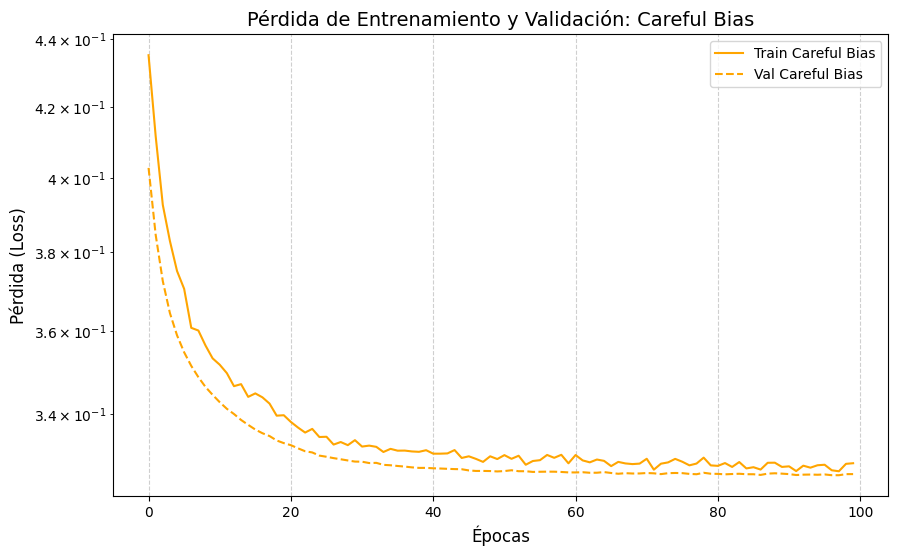

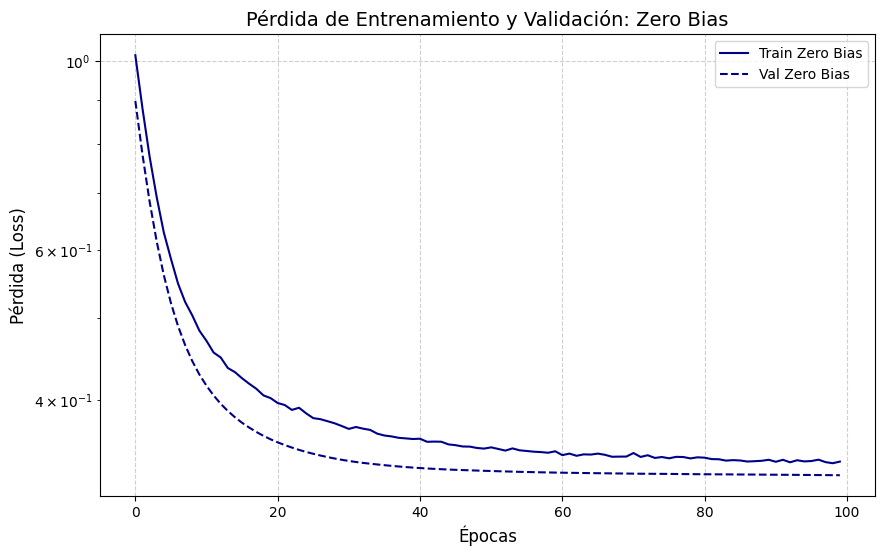

In [99]:
def plot_combined_loss(history, label, color):
    # Crear una figura para las pérdidas de entrenamiento y validación juntas
    plt.figure(figsize=(10, 6))
    
    # Graficar la pérdida de entrenamiento
    plt.semilogy(history.epoch, history.history['loss'],
                 color=color, label='Train ' + label)
    
    # Graficar la pérdida de validación
    plt.semilogy(history.epoch, history.history['val_loss'],
                 color=color, label='Val ' + label, linestyle="--")
    
    # Mejorar etiquetas y título
    plt.title(f"Pérdida de Entrenamiento y Validación: {label}", fontsize=14)
    plt.xlabel("Épocas", fontsize=12)
    plt.ylabel("Pérdida (Loss)", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle='--', alpha=0.6)  # Agregar una cuadrícula ligera
    plt.show()

# Graficar Train y Val para Careful Bias
plot_combined_loss(biased_history, "Careful Bias", "orange")

# Graficar Train y Val para Zero Bias
plot_combined_loss(baseline_history, "Zero Bias", "darkblue")

En las graficas de pérdida de ambos modelos podemos ver los siguientes resultados:

- **Inicio del entrenamiento**: El modelo con *Careful Bias* parte con menor pérdida inicial gracias a la calibración de salida; *Zero Bias* empieza con un valor de pérdida más alto.
- **Convergencia**: Ambos modelos reducen la pérdida de forma constante en entrenamiento y validación.
- **Dropout**: La pérdida de entrenamiento es ligeramente mayor por el ruido introducido, lo cual es normal.


## Model

In [ ]:
from tensorflow.keras.utils import plot_model

# Suponiendo que ya tienes tu modelo como "baseline_model"
plot_model(
    baseline_model,
    to_file="modelo_red.png",
    show_shapes=True,
    show_layer_names=True,
    dpi=96
)

You must install pydot (`pip install pydot`) for `plot_model` to work.


### Confusion Matrix

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 251us/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step


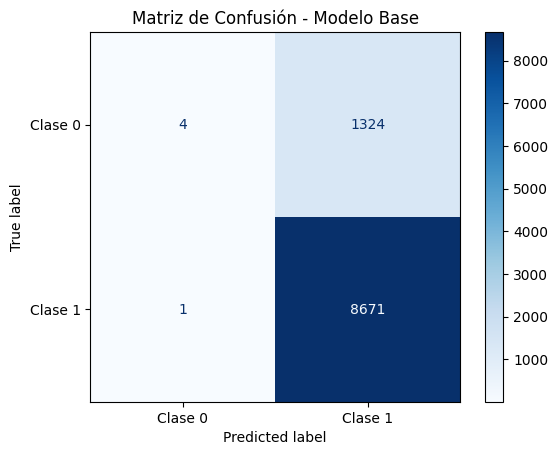

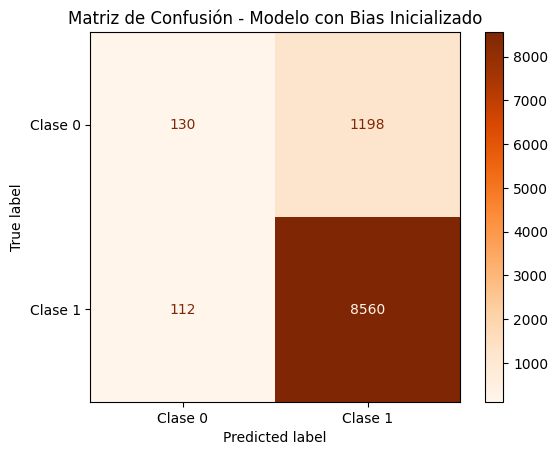

In [122]:

# Predicciones del modelo base
baseline_predictions = (baseline_model.predict(X_test) > 0.5).astype("int32")

# Predicciones del modelo con bias inicializado
biased_predictions = (biased_model.predict(X_test) > 0.5).astype("int32")

# Matriz de confusión para el modelo base
baseline_cm = confusion_matrix(y_test, baseline_predictions)
ConfusionMatrixDisplay(baseline_cm, display_labels=["Clase 0", "Clase 1"]).plot(cmap="Blues")
plt.title("Matriz de Confusión - Modelo Base")
plt.show()

# Matriz de confusión para el modelo con bias inicializado
biased_cm = confusion_matrix(y_test, biased_predictions)
ConfusionMatrixDisplay(biased_cm, display_labels=["Clase 0", "Clase 1"]).plot(cmap="Oranges")
plt.title("Matriz de Confusión - Modelo con Bias Inicializado")
plt.show()


Ambas matrices de confusión muestran que los modelos cometen muchos errores al clasificar la **clase 0**. Esto es lógico, ya que contamos con **pocas muestras de esta clase** en el conjunto de datos, lo que dificulta que los modelos aprendan a identificarla correctamente.

### Model Report

In [121]:
# Classification report para el modelo base
print("Classification Report - Modelo Base")
print(classification_report(y_test, baseline_predictions, target_names=["Clase 0", "Clase 1"]))

# Classification report para el modelo con bias inicializado
print("Classification Report - Modelo con Bias Inicializado")
print(classification_report(y_test, biased_predictions, target_names=["Clase 0", "Clase 1"]))

Classification Report - Modelo Base
              precision    recall  f1-score   support

     Clase 0       0.31      0.69      0.43      1328
     Clase 1       0.94      0.77      0.85      8672

    accuracy                           0.76     10000
   macro avg       0.63      0.73      0.64     10000
weighted avg       0.86      0.76      0.79     10000

Classification Report - Modelo con Bias Inicializado
              precision    recall  f1-score   support

     Clase 0       0.32      0.68      0.43      1328
     Clase 1       0.94      0.78      0.85      8672

    accuracy                           0.76     10000
   macro avg       0.63      0.73      0.64     10000
weighted avg       0.86      0.76      0.79     10000



### Decision Threshold Adjustment


Vamos a ajustar el parámetro **threshold** (umbral de decisión) para determinar el valor óptimo que permita lograr un balance adecuado entre **precisión** y **recall**. Este análisis es importante porque, dependiendo del problema, puede ser más crítico priorizar uno sobre el otro

**El objetivo es encontrar un umbral que optimice ambos valores según las necesidades del modelo**

**General**

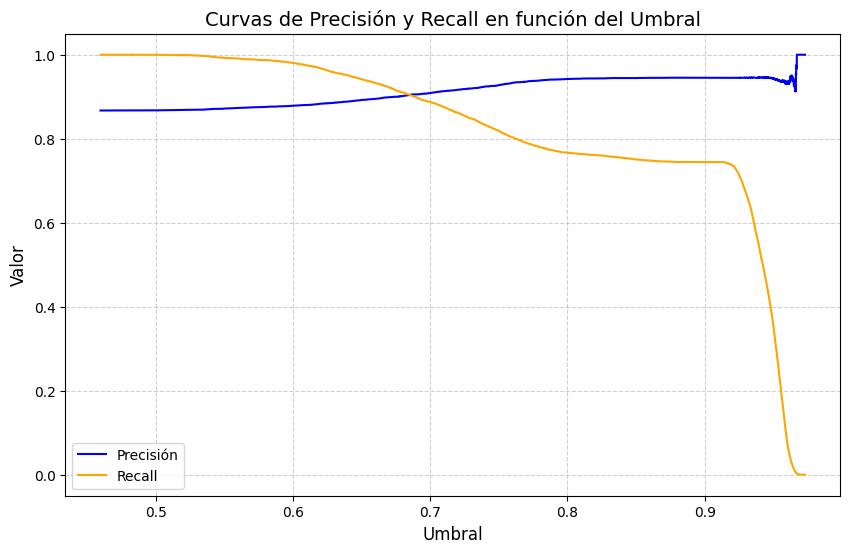

In [118]:
precision, recall, thresholds = precision_recall_curve(y_test, baseline_model(X_test))

# Graficar las curvas de precisión y recall
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label="Precisión", color="blue")
plt.plot(thresholds, recall[:-1], label="Recall", color="orange")
plt.xlabel("Umbral", fontsize=12)
plt.ylabel("Valor", fontsize=12)
plt.title("Curvas de Precisión y Recall en función del Umbral", fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 228us/step


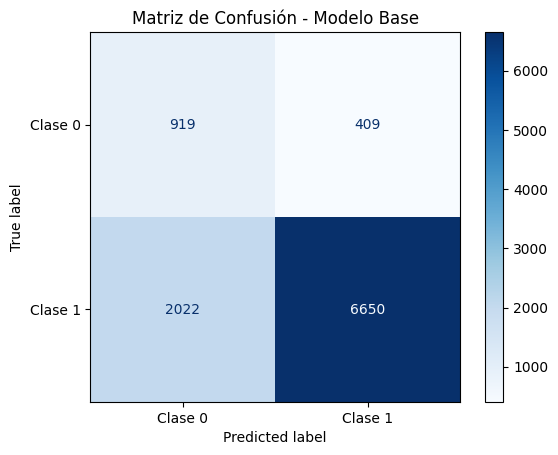

In [131]:
baseline_predictions = (baseline_model.predict(X_test) >0.8).astype("int32")
baseline_cm = confusion_matrix(y_test, baseline_predictions)
ConfusionMatrixDisplay(baseline_cm, display_labels=["Clase 0", "Clase 1"]).plot(cmap="Blues")
plt.title("Matriz de Confusión - Modelo Base")
plt.show()

In [132]:
# Classification report para el modelo base
print("Classification Report - Modelo Base")
print(classification_report(y_test, baseline_predictions, target_names=["Clase 0", "Clase 1"]))

Classification Report - Modelo Base
              precision    recall  f1-score   support

     Clase 0       0.31      0.69      0.43      1328
     Clase 1       0.94      0.77      0.85      8672

    accuracy                           0.76     10000
   macro avg       0.63      0.73      0.64     10000
weighted avg       0.86      0.76      0.79     10000



## Evolution Model

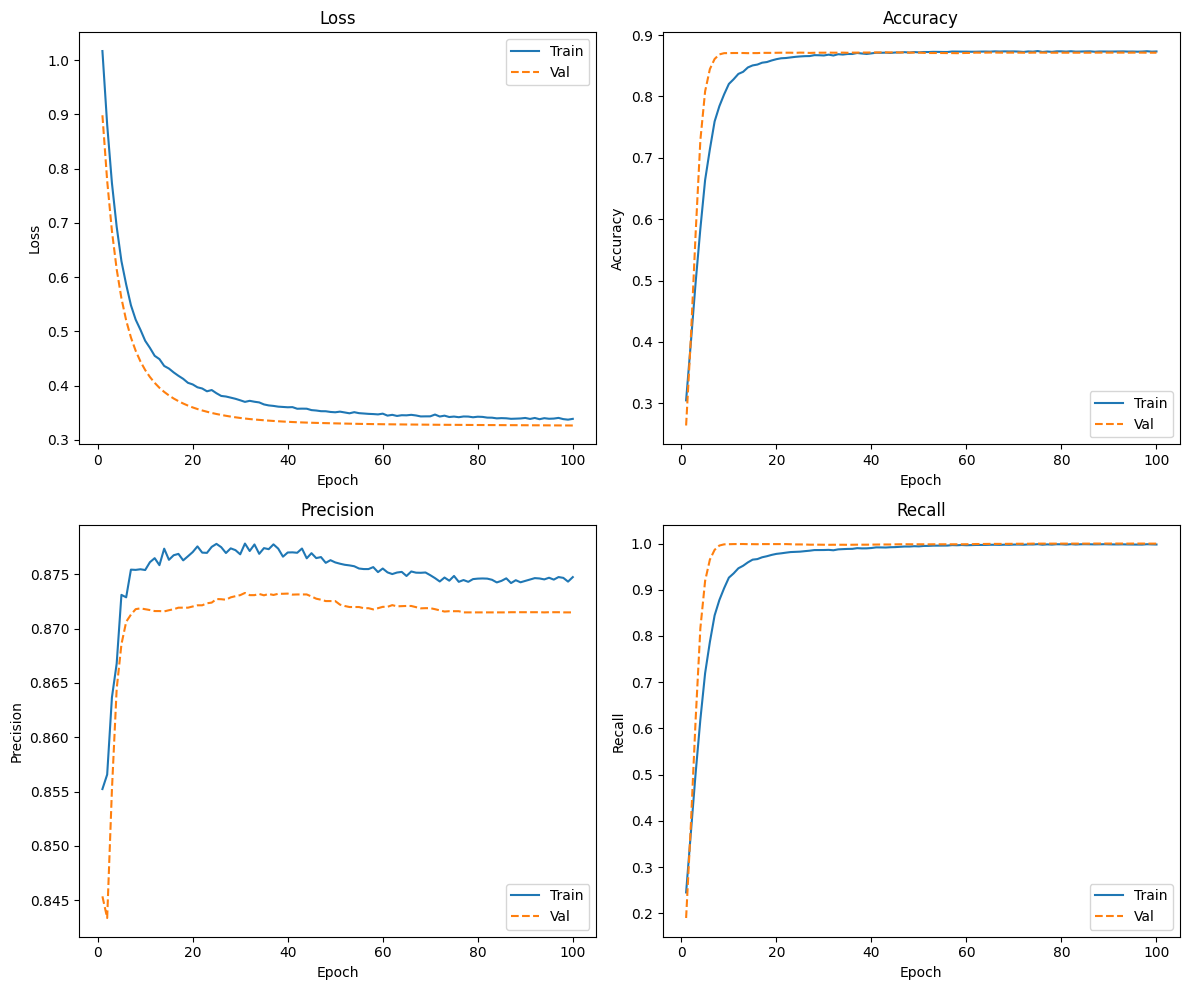

In [ ]:
history = baseline_history.history
epochs = range(1, len(history['loss']) + 1)


fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# --- 1. Pérdida (Loss)
axs[0, 0].plot(epochs, history['loss'], label='Train')
axs[0, 0].plot(epochs, history['val_loss'], '--', label='Val')
axs[0, 0].set_title('Loss')
axs[0, 0].set_xlabel('Epoch')
axs[0, 0].set_ylabel('Loss')
axs[0, 0].legend()

# --- 2. Exactitud (Binary Accuracy)
axs[0, 1].plot(epochs, history['binary_accuracy'], label='Train')
axs[0, 1].plot(epochs, history['val_binary_accuracy'], '--', label='Val')
axs[0, 1].set_title('Accuracy')
axs[0, 1].set_xlabel('Epoch')
axs[0, 1].set_ylabel('Accuracy')
axs[0, 1].legend()

# --- 3. Precisión
axs[1, 0].plot(epochs, history['precision_21'], label='Train')
axs[1, 0].plot(epochs, history['val_precision_21'], '--', label='Val')
axs[1, 0].set_title('Precision')
axs[1, 0].set_xlabel('Epoch')
axs[1, 0].set_ylabel('Precision')
axs[1, 0].legend()

# --- 4. Recall
axs[1, 1].plot(epochs, history['recall_21'], label='Train')
axs[1, 1].plot(epochs, history['val_recall_21'], '--', label='Val')
axs[1, 1].set_title('Recall')
axs[1, 1].set_xlabel('Epoch')
axs[1, 1].set_ylabel('Recall')
axs[1, 1].legend()

plt.tight_layout()
plt.show()

## Shap

In [21]:
import shap
import numpy as np

# Usamos un subconjunto del conjunto de entrenamiento como background
background = X_train.iloc[np.random.choice(X_train.shape[0], 100, replace=False)]

# Creamos el explainer para el modelo base
explainer = shap.KernelExplainer(baseline_model.predict, background)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


In [22]:
# Elegir un ejemplo de validación
i = 0
sample = X_val.iloc[[i]]  # Formato DataFrame

# Obtener los valores SHAP
shap_values = explainer.shap_values(sample)

  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 1s 184us/step


100%|██████████| 1/1 [00:02<00:00,  2.12s/it]



🩺 Gráfico SHAP para paciente 0


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 1s 186us/step


100%|██████████| 1/1 [00:01<00:00,  1.87s/it]


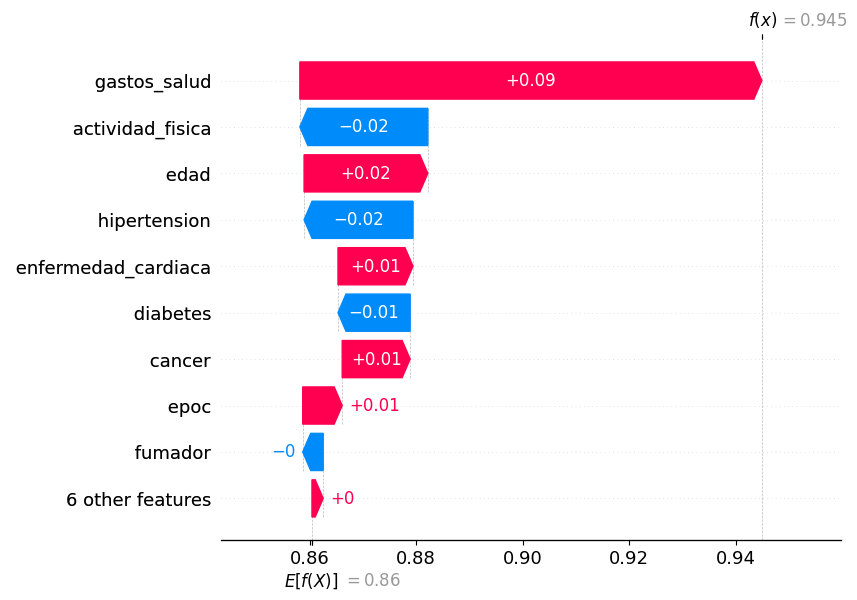


🩺 Gráfico SHAP para paciente 1


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 1s 186us/step


100%|██████████| 1/1 [00:02<00:00,  2.05s/it]


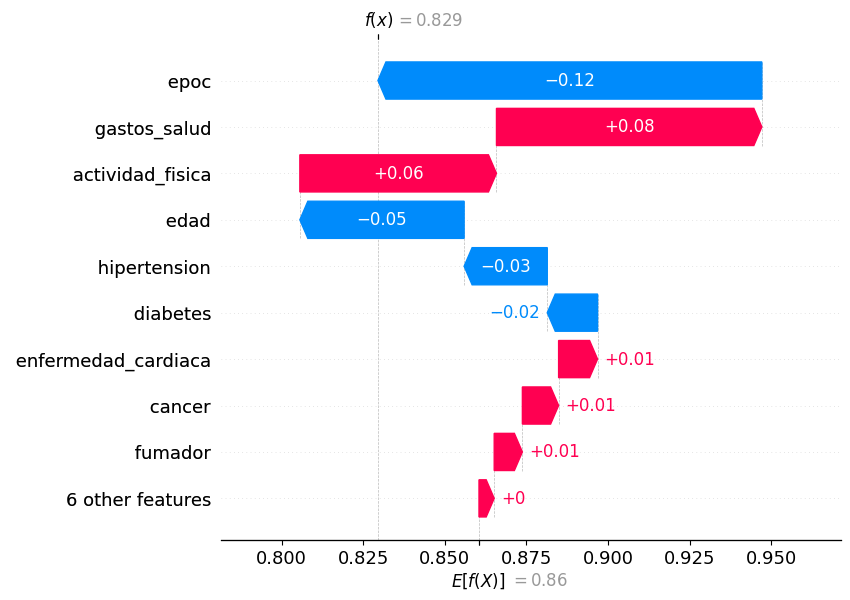


🩺 Gráfico SHAP para paciente 2


  0%|          | 0/1 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
6494/6494 ━━━━━━━━━━━━━━━━━━━━ 1s 189us/step


100%|██████████| 1/1 [00:01<00:00,  1.89s/it]


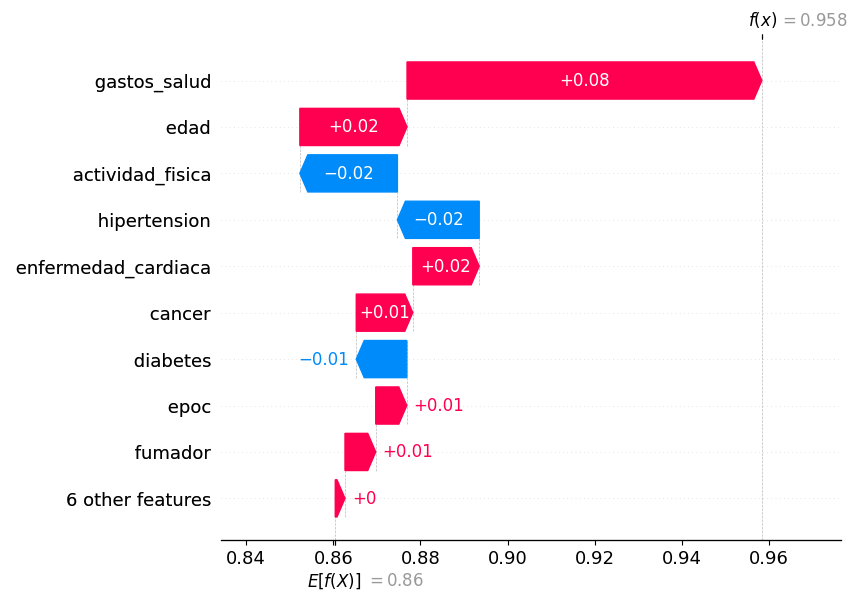

In [27]:
for i in range(3):  # Puedes cambiar el rango según cuantos pacientes quieras explorar
    print(f"\n🩺 Gráfico SHAP para paciente {i}")
    
    # Seleccionar el paciente i
    sample = X_val.iloc[[i]]  # Importante mantener doble corchete para que siga siendo DataFrame
    
    # Obtener los SHAP values para ese paciente
    shap_values = explainer.shap_values(sample)
    
    # Graficar waterfall
    shap.plots._waterfall.waterfall_legacy(
        explainer.expected_value[0],
        shap_values[0].flatten(),
        sample.iloc[0]
    )

## Save

In [18]:
import tensorflow as tf
import joblib

# Guardar el modelo de Keras (por ejemplo, baseline_model)
baseline_model.save("baseline_model_tf.keras")

# Guardar el scaler de sklearn (StandardScaler)
joblib.dump(scaler, "scaler.save")

['scaler.save']

## Class Weight

In [ ]:
# Calcular los pesos de las clases automáticamente
class_weights = compute_class_weight(class_weight='balanced', classes=np.array([0, 1]), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}


In [183]:
print(class_weight_dict)

{0: np.float64(3.9408866995073892), 1: np.float64(0.572655690765927)}


In [166]:
# Definir el modelo con más neuronas y class_weight
def make_model_with_class_weight():
    model = Sequential([
        Dense(32, activation='relu', input_shape=(X_train.shape[1],)),  # Aumentado a 32 neuronas
        Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=[BinaryAccuracy(), Precision(), Recall()]
    )
    return model

# Crear el modelo
class_weight_model = make_model_with_class_weight()

# Entrenar el modelo con class_weight
class_weight_history = class_weight_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    verbose=1,
    class_weight=class_weight_dict
)

Epoch 1/100


/Users/martinagarciagonzalez/Library/Python/3.12/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 1s 570us/step - binary_accuracy: 0.5705 - loss: 0.6765 - precision_28: 0.9136 - recall_28: 0.5613 - val_binary_accuracy: 0.7584 - val_loss: 0.6027 - val_precision_28: 0.9457 - val_recall_28: 0.7668
Epoch 2/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - binary_accuracy: 0.7371 - loss: 0.5903 - precision_28: 0.9444 - recall_28: 0.7421 - val_binary_accuracy: 0.7604 - val_loss: 0.5737 - val_precision_28: 0.9468 - val_recall_28: 0.7682
Epoch 3/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 446us/step - binary_accuracy: 0.7521 - loss: 0.5907 - precision_28: 0.9440 - recall_28: 0.7615 - val_binary_accuracy: 0.7485 - val_loss: 0.5839 - val_precision_28: 0.9478 - val_recall_28: 0.7529
Epoch 4/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 442us/step - binary_accuracy: 0.7513 - loss: 0.5816 - precision_28: 0.9471 - recall_28: 0.7575 - val_binary_accuracy: 0.7536 - val_loss: 0.5541 - val_precision_28: 0.9471 - val_recall_28: 0.7598
Epoch 5/100
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 0s 44

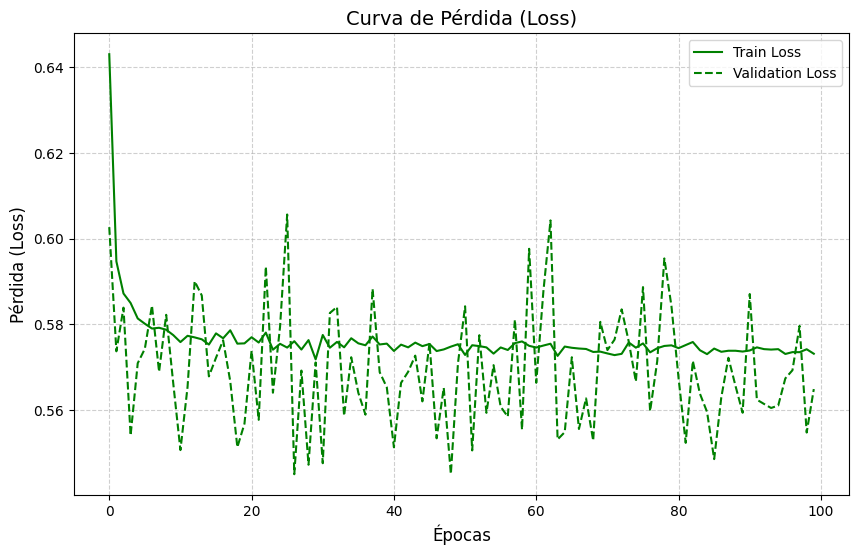

In [174]:
# Crear una figura para las pérdidas de entrenamiento y validación
plt.figure(figsize=(10, 6))

# Graficar la pérdida de entrenamiento
plt.plot(class_weight_history .epoch, class_weight_history .history['loss'], label='Train Loss', color='green')

# Graficar la pérdida de validación
plt.plot(class_weight_history .epoch, class_weight_history .history['val_loss'], label='Validation Loss', color='green', linestyle="--")

# Mejorar etiquetas y título
plt.title("Curva de Pérdida (Loss)", fontsize=14)
plt.xlabel("Épocas", fontsize=12)
plt.ylabel("Pérdida (Loss)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)  # Agregar una cuadrícula ligera
plt.show()

**¿Por qué se generan estas oscilaciones?**

Las oscilaciones en la función de pérdida se generan porque al darle más peso a la clase minoritaria (clase 0) en la función de pérdida, el modelo intenta ajustar sus predicciones para minimizar los errores en esta clase. Esto puede causar que el modelo sea más sensible a pequeñas variaciones en los datos, lo que resulta en una curva de pérdida más irregular. Este comportamiento es común cuando se trabaja con clases desbalanceadas y se utilizan técnicas como `class_weight` o `focal loss`.

*¿Ajustar el threshold o esperar?*

En la vida real, la decisión depende del contexto del problema:

1. **Ajustar el threshold**: Si el objetivo es optimizar métricas específicas como precisión o recall, ajustar el umbral de decisión puede ser una estrategia válida. Esto es especialmente útil en problemas donde es más importante minimizar falsos positivos o falsos negativos, dependiendo del caso de uso.

2. **Esperar y mejorar el modelo**: Si las oscilaciones son demasiado pronunciadas, puede ser mejor ajustar otros aspectos del modelo, como:
    - Recolectar más datos para la clase minoritaria.
    - Probar arquitecturas más robustas.
    - Usar técnicas de regularización para reducir la sensibilidad del modelo.

En resumen, ajustar el threshold es una solución práctica si el modelo ya tiene un rendimiento aceptable y el objetivo es optimizar métricas específicas. Sin embargo, si las oscilaciones son un síntoma de un modelo inestable, puede ser mejor enfocarse en mejorar el modelo antes de ajustar el threshold.

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 434us/step


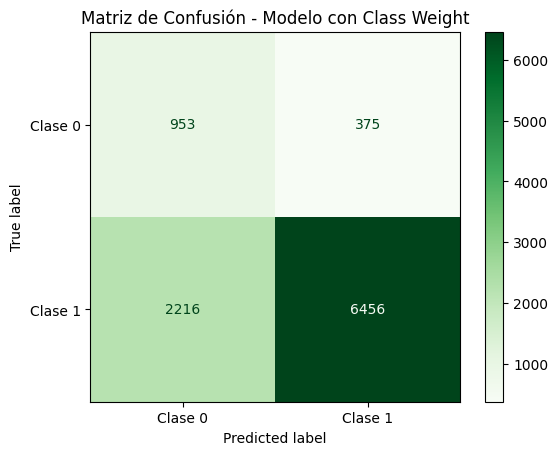

In [175]:
# Predicciones del modelo con class_weight
class_weight_predictions = (class_weight_model.predict(X_test) > 0.5).astype("int32")

# Matriz de confusión para el modelo con class_weight
class_weight_cm = confusion_matrix(y_test, class_weight_predictions)
ConfusionMatrixDisplay(class_weight_cm, display_labels=["Clase 0", "Clase 1"]).plot(cmap="Greens")
plt.title("Matriz de Confusión - Modelo con Class Weight")
plt.show()

In [176]:
# Predicciones del modelo con class_weight
class_weight_predictions = (class_weight_model.predict(X_test) > 0.5).astype("int32")

# Classification report para el modelo con class_weight
print("Classification Report - Modelo con Class Weight")
print(classification_report(y_test, class_weight_predictions, target_names=["Clase 0", "Clase 1"]))

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 225us/step
Classification Report - Modelo con Class Weight
              precision    recall  f1-score   support

     Clase 0       0.30      0.72      0.42      1328
     Clase 1       0.95      0.74      0.83      8672

    accuracy                           0.74     10000
   macro avg       0.62      0.73      0.63     10000
weighted avg       0.86      0.74      0.78     10000



In [172]:
history = class_weight_history.history
epochs = range(1, len(history['loss']) + 1)

## SMOTE

In [184]:
# Aplicar SMOTE para balancear las clases
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("Distribución de clases después de SMOTE:")
print(y_train_smote.value_counts())


Distribución de clases después de SMOTE:
vive
1    27940
0    27940
Name: count, dtype: int64


In [185]:
# Definir el modelo
def make_model_with_smote():
    model = Sequential([
        Dense(32, activation='relu', input_shape=(X_train_smote.shape[1],)),  # Aumentado a 32 neuronas
        Dropout(0.4),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=Adam(learning_rate=1e-3),
        loss='binary_crossentropy',
        metrics=[BinaryAccuracy(), Precision(), Recall()]
    )
    return model

# Crear el modelo
smote_model = make_model_with_smote()

# Entrenar el modelo con los datos balanceados por SMOTE
smote_history = smote_model.fit(
    X_train_smote, y_train_smote,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    verbose=1
)

Epoch 1/100


/Users/martinagarciagonzalez/Library/Python/3.12/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1747/1747 ━━━━━━━━━━━━━━━━━━━━ 1s 513us/step - binary_accuracy: 0.6638 - loss: 0.6320 - precision_30: 0.6515 - recall_30: 0.7017 - val_binary_accuracy: 0.7660 - val_loss: 0.5428 - val_precision_30: 0.9461 - val_recall_30: 0.7757
Epoch 2/100
1747/1747 ━━━━━━━━━━━━━━━━━━━━ 1s 426us/step - binary_accuracy: 0.7254 - loss: 0.5802 - precision_30: 0.7065 - recall_30: 0.7692 - val_binary_accuracy: 0.7660 - val_loss: 0.5563 - val_precision_30: 0.9461 - val_recall_30: 0.7757
Epoch 3/100
1747/1747 ━━━━━━━━━━━━━━━━━━━━ 1s 476us/step - binary_accuracy: 0.7294 - loss: 0.5757 - precision_30: 0.7122 - recall_30: 0.7678 - val_binary_accuracy: 0.7646 - val_loss: 0.5676 - val_precision_30: 0.9462 - val_recall_30: 0.7740
Epoch 4/100
1747/1747 ━━━━━━━━━━━━━━━━━━━━ 1s 414us/step - binary_accuracy: 0.7334 - loss: 0.5688 - precision_30: 0.7207 - recall_30: 0.7648 - val_binary_accuracy: 0.7653 - val_loss: 0.5700 - val_precision_30: 0.9464 - val_recall_30: 0.7745
Epoch 5/100
1747/1747 ━━━━━━━━━━━━━━━━━━━━ 1s 42

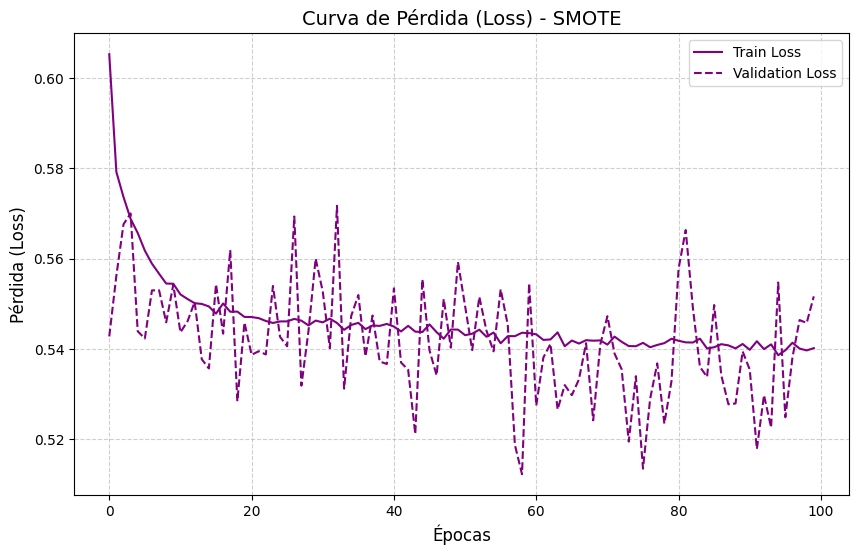

In [187]:
# Crear una figura para las pérdidas de entrenamiento y validación
plt.figure(figsize=(10, 6))

# Graficar la pérdida de entrenamiento
plt.plot(smote_history.epoch, smote_history.history['loss'], label='Train Loss', color='purple')

# Graficar la pérdida de validación
plt.plot(smote_history.epoch, smote_history.history['val_loss'], label='Validation Loss', color='purple', linestyle="--")

# Mejorar etiquetas y título
plt.title("Curva de Pérdida (Loss) - SMOTE", fontsize=14)
plt.xlabel("Épocas", fontsize=12)
plt.ylabel("Pérdida (Loss)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)  # Agregar una cuadrícula ligera
plt.show()